In [1]:
import os, json, sys, time, random
import numpy as np
import torch
from  easydict import EasyDict
from math import floor
from easydict import EasyDict

from steves_utils.vanilla_train_eval_test_jig import  Vanilla_Train_Eval_Test_Jig

from steves_utils.torch_utils import get_dataset_metrics, independent_accuracy_assesment
from steves_models.configurable_vanilla import Configurable_Vanilla
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.lazy_map import Lazy_Map
from steves_utils.sequence_aggregator import Sequence_Aggregator

from steves_utils.stratified_dataset.traditional_accessor import Traditional_Accessor_Factory

from steves_utils.cnn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.torch_utils import (
    confusion_by_domain_over_dataloader,
    independent_accuracy_assesment
)

from steves_utils.utils_v2 import (
    per_domain_accuracy_from_confusion,
    get_datasets_base_path
)

# from steves_utils.ptn_do_report import TBD

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "dataset_seed",
    "seed",
    "labels",
    "domains_target",
    "domains_source",
    "num_examples_per_domain_per_label_source",
    "num_examples_per_domain_per_label_target",
    "batch_size",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "normalize_source",
    "normalize_target",
    "x_net",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "pickle_name_source",
    "pickle_name_target",
    "torch_default_dtype",
}

In [3]:
from steves_utils.ORACLE.utils_v2 import (
    ALL_SERIAL_NUMBERS,
    ALL_DISTANCES_FEET_NARROWED,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "MANUAL CORES CNN"
standalone_parameters["lr"] = 0.0001
standalone_parameters["device"] = "cuda"

standalone_parameters["dataset_seed"] = 1337
standalone_parameters["seed"] = 1337
standalone_parameters["labels"] = ALL_SERIAL_NUMBERS

standalone_parameters["domains_source"] = [8,32,50]
standalone_parameters["domains_target"] = [14,20,26,38,44,]

standalone_parameters["num_examples_per_domain_per_label_source"]=-1
standalone_parameters["num_examples_per_domain_per_label_target"]=-1

standalone_parameters["pickle_name_source"] = "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"
standalone_parameters["pickle_name_target"] = "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"

standalone_parameters["torch_default_dtype"] = "torch.float32" 

standalone_parameters["batch_size"]=128

standalone_parameters["n_epoch"] = 3

standalone_parameters["patience"] = 10

standalone_parameters["criteria_for_best"] = "target_accuracy"
standalone_parameters["normalize_source"] = False
standalone_parameters["normalize_target"] = False

standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": len(standalone_parameters["labels"])}},
]

standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"

In [4]:
# Parameters
parameters = {
    "experiment_name": "cnn_2:oracle.run2_limited",
    "labels": [
        "3123D52",
        "3123D65",
        "3123D79",
        "3123D80",
        "3123D54",
        "3123D70",
        "3123D7B",
        "3123D89",
        "3123D58",
        "3123D76",
        "3123D7D",
        "3123EFE",
        "3123D64",
        "3123D78",
        "3123D7E",
        "3124E4A",
    ],
    "domains_source": [8, 32, 50, 14, 20, 26, 38, 44],
    "domains_target": [8, 32, 50, 14, 20, 26, 38, 44],
    "pickle_name_source": "oracle.Run2_10kExamples_stratified_ds.2022A.pkl",
    "pickle_name_target": "oracle.Run2_10kExamples_stratified_ds.2022A.pkl",
    "device": "cuda",
    "lr": 0.0001,
    "batch_size": 128,
    "normalize_source": False,
    "normalize_target": False,
    "num_examples_per_domain_per_label_source": 2000,
    "num_examples_per_domain_per_label_target": 2000,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 16}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "dataset_seed": 1337,
    "seed": 1337,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
def wrap_in_dataloader(p, ds):
    return torch.utils.data.DataLoader(
        ds,
        batch_size=p.batch_size,
        shuffle=True,
        num_workers=1,
        persistent_workers=True,
        prefetch_factor=50,
        pin_memory=True
    )

taf_source = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_source,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_source),
    seed=p.dataset_seed
)
train_original_source, val_original_source, test_original_source = \
    taf_source.get_train(), taf_source.get_val(), taf_source.get_test()


taf_target = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_target,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_target),
    seed=p.dataset_seed
)
train_original_target, val_original_target, test_original_target = \
    taf_target.get_train(), taf_target.get_val(), taf_target.get_test()


# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Map. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[:2] # Strip the tuple to just (x,y)


train_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_source, transform_lambda)
)
val_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_source, transform_lambda)
)
test_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_source, transform_lambda)
)

train_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_target, transform_lambda)
)
val_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_target, transform_lambda)
)
test_processed_target  = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_target, transform_lambda)
)



datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [11]:
ep = next(iter(test_processed_target))
ep[0].dtype

torch.float32

In [12]:
model = Configurable_Vanilla(
    x_net=x_net,
    label_loss_object=torch.nn.NLLLoss(),
    learning_rate=p.lr
)

In [13]:
jig = Vanilla_Train_Eval_Test_Jig(
    model=model,
    path_to_best_model=p.BEST_MODEL_PATH,
    device=p.device,
    label_loss_object=torch.nn.NLLLoss(),
)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    patience=p.patience,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    criteria_for_best=p.criteria_for_best
)

epoch: 1, [batch: 1 / 1400], examples_per_second: 768.2645, train_label_loss: 2.8080, 


epoch: 1, [batch: 140 / 1400], examples_per_second: 11727.8513, train_label_loss: 2.6889, 


epoch: 1, [batch: 280 / 1400], examples_per_second: 11677.6891, train_label_loss: 2.7492, 


epoch: 1, [batch: 420 / 1400], examples_per_second: 11598.9842, train_label_loss: 2.5542, 


epoch: 1, [batch: 560 / 1400], examples_per_second: 11597.9675, train_label_loss: 2.6042, 


epoch: 1, [batch: 700 / 1400], examples_per_second: 11560.6541, train_label_loss: 2.5391, 


epoch: 1, [batch: 840 / 1400], examples_per_second: 11693.5242, train_label_loss: 2.6241, 


epoch: 1, [batch: 980 / 1400], examples_per_second: 11687.5910, train_label_loss: 2.6197, 


epoch: 1, [batch: 1120 / 1400], examples_per_second: 11719.5500, train_label_loss: 2.5042, 


epoch: 1, [batch: 1260 / 1400], examples_per_second: 11700.3868, train_label_loss: 2.3921, 


epoch: 1, source_val_acc_label: 0.1564, source_val_label_loss: 2.5274, target_val_acc_label: 0.1564, target_val_label_loss: 2.5274, 


New best
epoch: 2, [batch: 1 / 1400], examples_per_second: 55.2688, train_label_loss: 2.4515, 


epoch: 2, [batch: 140 / 1400], examples_per_second: 11589.1940, train_label_loss: 2.2552, 


epoch: 2, [batch: 280 / 1400], examples_per_second: 11622.8090, train_label_loss: 2.2464, 


epoch: 2, [batch: 420 / 1400], examples_per_second: 11643.5780, train_label_loss: 2.2074, 


epoch: 2, [batch: 560 / 1400], examples_per_second: 11666.6412, train_label_loss: 2.3288, 


epoch: 2, [batch: 700 / 1400], examples_per_second: 11554.4606, train_label_loss: 2.2238, 


epoch: 2, [batch: 840 / 1400], examples_per_second: 11554.8407, train_label_loss: 2.2482, 


epoch: 2, [batch: 980 / 1400], examples_per_second: 11644.6712, train_label_loss: 2.2262, 


epoch: 2, [batch: 1120 / 1400], examples_per_second: 11698.7551, train_label_loss: 2.2293, 


epoch: 2, [batch: 1260 / 1400], examples_per_second: 11647.4953, train_label_loss: 2.0279, 


epoch: 2, source_val_acc_label: 0.3364, source_val_label_loss: 2.0015, target_val_acc_label: 0.3364, target_val_label_loss: 2.0015, 


New best
epoch: 3, [batch: 1 / 1400], examples_per_second: 65.4364, train_label_loss: 1.9820, 


epoch: 3, [batch: 140 / 1400], examples_per_second: 12567.1713, train_label_loss: 1.8996, 


epoch: 3, [batch: 280 / 1400], examples_per_second: 11864.4494, train_label_loss: 1.8016, 


epoch: 3, [batch: 420 / 1400], examples_per_second: 11631.6027, train_label_loss: 1.9323, 


epoch: 3, [batch: 560 / 1400], examples_per_second: 11555.1835, train_label_loss: 1.8577, 


epoch: 3, [batch: 700 / 1400], examples_per_second: 11631.3615, train_label_loss: 1.9780, 


epoch: 3, [batch: 840 / 1400], examples_per_second: 11721.3612, train_label_loss: 1.8036, 


epoch: 3, [batch: 980 / 1400], examples_per_second: 11655.8203, train_label_loss: 1.8412, 


epoch: 3, [batch: 1120 / 1400], examples_per_second: 11635.3930, train_label_loss: 1.6908, 


epoch: 3, [batch: 1260 / 1400], examples_per_second: 11663.0061, train_label_loss: 1.6831, 


epoch: 3, source_val_acc_label: 0.4469, source_val_label_loss: 1.6563, target_val_acc_label: 0.4469, target_val_label_loss: 1.6563, 


New best
epoch: 4, [batch: 1 / 1400], examples_per_second: 63.6419, train_label_loss: 1.4011, 


epoch: 4, [batch: 140 / 1400], examples_per_second: 11508.1088, train_label_loss: 1.6027, 


epoch: 4, [batch: 280 / 1400], examples_per_second: 11619.7094, train_label_loss: 1.7283, 


epoch: 4, [batch: 420 / 1400], examples_per_second: 11850.4796, train_label_loss: 1.5807, 


epoch: 4, [batch: 560 / 1400], examples_per_second: 11648.2697, train_label_loss: 1.4849, 


epoch: 4, [batch: 700 / 1400], examples_per_second: 11567.0020, train_label_loss: 1.4234, 


epoch: 4, [batch: 840 / 1400], examples_per_second: 11606.7721, train_label_loss: 1.5934, 


epoch: 4, [batch: 980 / 1400], examples_per_second: 11503.4335, train_label_loss: 1.5602, 


epoch: 4, [batch: 1120 / 1400], examples_per_second: 11597.9353, train_label_loss: 1.3479, 


epoch: 4, [batch: 1260 / 1400], examples_per_second: 11646.0695, train_label_loss: 1.3792, 


epoch: 4, source_val_acc_label: 0.4623, source_val_label_loss: 1.5624, target_val_acc_label: 0.4623, target_val_label_loss: 1.5624, 


New best
epoch: 5, [batch: 1 / 1400], examples_per_second: 64.3501, train_label_loss: 1.1314, 


epoch: 5, [batch: 140 / 1400], examples_per_second: 11549.7531, train_label_loss: 1.1845, 


epoch: 5, [batch: 280 / 1400], examples_per_second: 11631.4173, train_label_loss: 1.2861, 


epoch: 5, [batch: 420 / 1400], examples_per_second: 11687.4129, train_label_loss: 1.2371, 


epoch: 5, [batch: 560 / 1400], examples_per_second: 11752.4891, train_label_loss: 1.1222, 


epoch: 5, [batch: 700 / 1400], examples_per_second: 11730.7917, train_label_loss: 1.2415, 


epoch: 5, [batch: 840 / 1400], examples_per_second: 11671.8626, train_label_loss: 1.1632, 


epoch: 5, [batch: 980 / 1400], examples_per_second: 11671.2518, train_label_loss: 1.1917, 


epoch: 5, [batch: 1120 / 1400], examples_per_second: 11644.1480, train_label_loss: 1.1797, 


epoch: 5, [batch: 1260 / 1400], examples_per_second: 11658.6118, train_label_loss: 1.4827, 


epoch: 5, source_val_acc_label: 0.4995, source_val_label_loss: 1.4411, target_val_acc_label: 0.4995, target_val_label_loss: 1.4411, 


New best
epoch: 6, [batch: 1 / 1400], examples_per_second: 63.8512, train_label_loss: 0.9706, 


epoch: 6, [batch: 140 / 1400], examples_per_second: 11562.5913, train_label_loss: 0.8194, 


epoch: 6, [batch: 280 / 1400], examples_per_second: 11698.6076, train_label_loss: 0.8584, 


epoch: 6, [batch: 420 / 1400], examples_per_second: 11762.2864, train_label_loss: 0.9633, 


epoch: 6, [batch: 560 / 1400], examples_per_second: 11771.3497, train_label_loss: 1.2265, 


epoch: 6, [batch: 700 / 1400], examples_per_second: 11698.6294, train_label_loss: 0.9218, 


epoch: 6, [batch: 840 / 1400], examples_per_second: 11694.1191, train_label_loss: 0.8360, 


epoch: 6, [batch: 980 / 1400], examples_per_second: 11636.6161, train_label_loss: 0.8640, 


epoch: 6, [batch: 1120 / 1400], examples_per_second: 11635.1318, train_label_loss: 0.9394, 


epoch: 6, [batch: 1260 / 1400], examples_per_second: 11785.9595, train_label_loss: 0.9768, 


epoch: 6, source_val_acc_label: 0.4908, source_val_label_loss: 1.4546, target_val_acc_label: 0.4908, target_val_label_loss: 1.4546, 


epoch: 7, [batch: 1 / 1400], examples_per_second: 65.0579, train_label_loss: 0.7685, 


epoch: 7, [batch: 140 / 1400], examples_per_second: 11604.7254, train_label_loss: 0.6315, 


epoch: 7, [batch: 280 / 1400], examples_per_second: 11675.5594, train_label_loss: 0.6150, 


epoch: 7, [batch: 420 / 1400], examples_per_second: 11551.0743, train_label_loss: 0.7229, 


epoch: 7, [batch: 560 / 1400], examples_per_second: 11706.6083, train_label_loss: 0.9037, 


epoch: 7, [batch: 700 / 1400], examples_per_second: 11755.8530, train_label_loss: 0.7423, 


epoch: 7, [batch: 840 / 1400], examples_per_second: 11721.2259, train_label_loss: 0.6724, 


epoch: 7, [batch: 980 / 1400], examples_per_second: 11741.1764, train_label_loss: 0.9406, 


epoch: 7, [batch: 1120 / 1400], examples_per_second: 11694.7341, train_label_loss: 0.6522, 


epoch: 7, [batch: 1260 / 1400], examples_per_second: 11747.0137, train_label_loss: 0.7343, 


epoch: 7, source_val_acc_label: 0.4958, source_val_label_loss: 1.4830, target_val_acc_label: 0.4958, target_val_label_loss: 1.4830, 


epoch: 8, [batch: 1 / 1400], examples_per_second: 64.0279, train_label_loss: 0.5364, 


epoch: 8, [batch: 140 / 1400], examples_per_second: 11555.5817, train_label_loss: 0.5379, 


epoch: 8, [batch: 280 / 1400], examples_per_second: 11658.9066, train_label_loss: 0.5951, 


epoch: 8, [batch: 420 / 1400], examples_per_second: 11744.9853, train_label_loss: 0.6554, 


epoch: 8, [batch: 560 / 1400], examples_per_second: 11696.1099, train_label_loss: 0.4688, 


epoch: 8, [batch: 700 / 1400], examples_per_second: 11664.9374, train_label_loss: 0.6062, 


epoch: 8, [batch: 840 / 1400], examples_per_second: 11611.8790, train_label_loss: 0.4445, 


epoch: 8, [batch: 980 / 1400], examples_per_second: 11709.2984, train_label_loss: 0.6896, 


epoch: 8, [batch: 1120 / 1400], examples_per_second: 11672.0565, train_label_loss: 0.5636, 


epoch: 8, [batch: 1260 / 1400], examples_per_second: 11668.7513, train_label_loss: 0.5683, 


epoch: 8, source_val_acc_label: 0.4913, source_val_label_loss: 1.5469, target_val_acc_label: 0.4913, target_val_label_loss: 1.5469, 


epoch: 9, [batch: 1 / 1400], examples_per_second: 64.8673, train_label_loss: 0.3077, 


epoch: 9, [batch: 140 / 1400], examples_per_second: 11636.9494, train_label_loss: 0.4964, 


epoch: 9, [batch: 280 / 1400], examples_per_second: 11639.9194, train_label_loss: 0.5126, 


epoch: 9, [batch: 420 / 1400], examples_per_second: 11682.8277, train_label_loss: 0.4222, 


epoch: 9, [batch: 560 / 1400], examples_per_second: 11692.4801, train_label_loss: 0.5141, 


epoch: 9, [batch: 700 / 1400], examples_per_second: 11732.3500, train_label_loss: 0.3641, 


epoch: 9, [batch: 840 / 1400], examples_per_second: 11696.7179, train_label_loss: 0.3802, 


epoch: 9, [batch: 980 / 1400], examples_per_second: 11736.3456, train_label_loss: 0.5000, 


epoch: 9, [batch: 1120 / 1400], examples_per_second: 11719.4988, train_label_loss: 0.4539, 


epoch: 9, [batch: 1260 / 1400], examples_per_second: 11669.9072, train_label_loss: 0.4177, 


epoch: 9, source_val_acc_label: 0.4690, source_val_label_loss: 1.7299, target_val_acc_label: 0.4690, target_val_label_loss: 1.7299, 


Patience (3) exhausted


In [14]:
total_experiment_time_secs = time.time() - start_time_secs

In [15]:
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = wrap_in_dataloader(p, Sequence_Aggregator((datasets.source.original.val, datasets.target.original.val)))

confusion = confusion_by_domain_over_dataloader(model, p.device, val_dl, forward_uses_domain=False)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

###################################
# Write out the results
###################################

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": p,
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "cnn"),
}

<AxesSubplot:title={'center':'Source Train Label Loss vs Source Val Label Loss'}, xlabel='Epoch'>

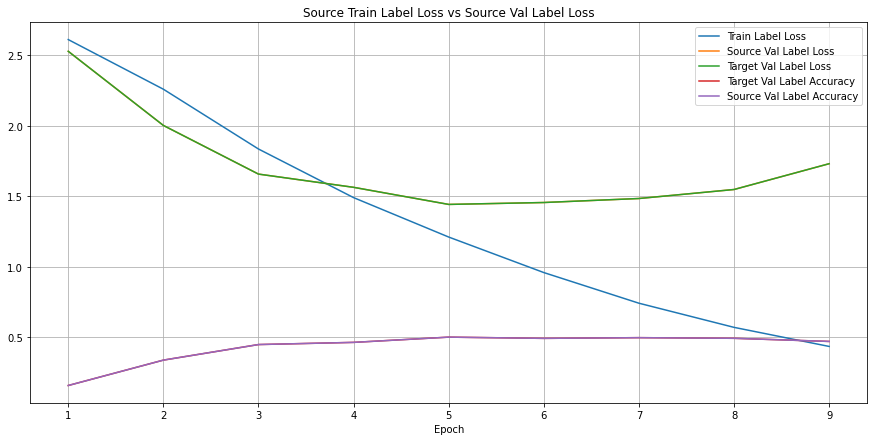

In [16]:
get_loss_curve(experiment)

<AxesSubplot:title={'center':'Results'}>

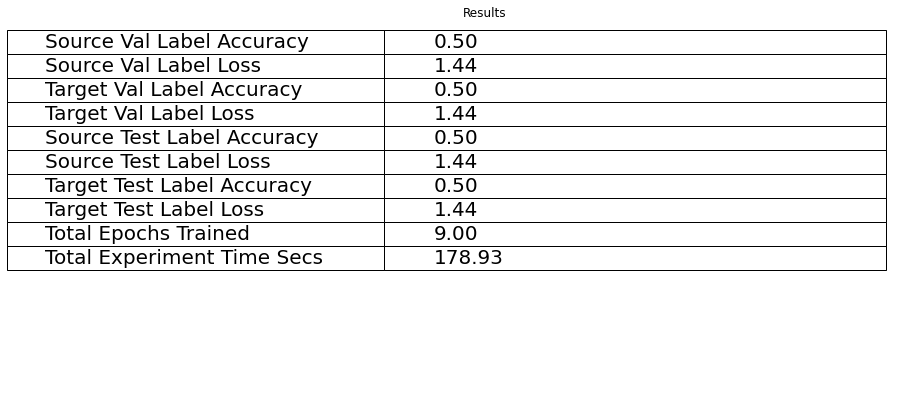

In [17]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Accuracy'}, xlabel='domain'>

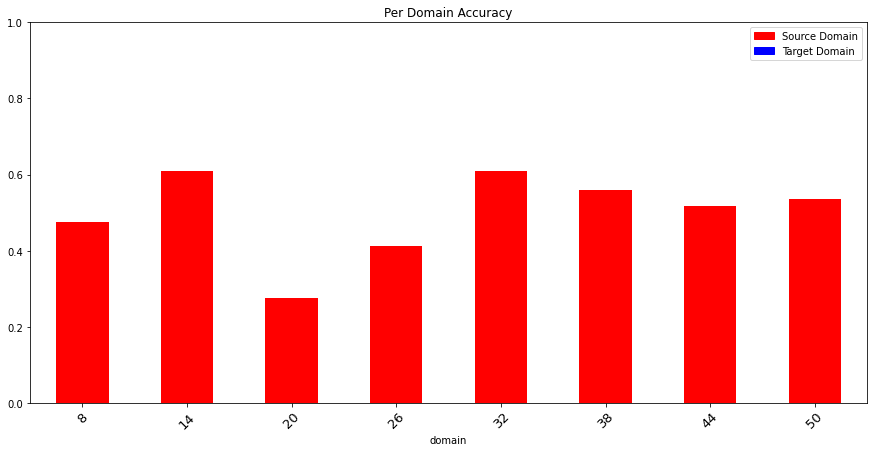

In [18]:
get_domain_accuracies(experiment)

In [19]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.5008854166666666 Target Test Label Accuracy: 0.5008854166666666
Source Val Label Accuracy: 0.49953125 Target Val Label Accuracy: 0.49953125


In [20]:
json.dumps(experiment)

'{"experiment_name": "cnn_2:oracle.run2_limited", "parameters": {"experiment_name": "cnn_2:oracle.run2_limited", "labels": ["3123D52", "3123D65", "3123D79", "3123D80", "3123D54", "3123D70", "3123D7B", "3123D89", "3123D58", "3123D76", "3123D7D", "3123EFE", "3123D64", "3123D78", "3123D7E", "3124E4A"], "domains_source": [8, 32, 50, 14, 20, 26, 38, 44], "domains_target": [8, 32, 50, 14, 20, 26, 38, 44], "pickle_name_source": "oracle.Run2_10kExamples_stratified_ds.2022A.pkl", "pickle_name_target": "oracle.Run2_10kExamples_stratified_ds.2022A.pkl", "device": "cuda", "lr": 0.0001, "batch_size": 128, "normalize_source": false, "normalize_target": false, "num_examples_per_domain_per_label_source": 2000, "num_examples_per_domain_per_label_target": 2000, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 2